In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("hw4.ipynb")

---

<h1><center>SDSE Homework 4 <br><br> Text Classification with Naive Bayes </center></h1>

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In this homework we will apply the technique of Naive Bayes classification to the problem of categorizing text-based documents. The dataset is a selection of posts from scikit-learn's ['20 newsgroups' dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), which contains some 18000 newsgroup posts in 20 different categories, such as politics, autos, electronics, atheism, and hockey. For simplicity, we will focus on just two of the categories: computer graphics and motorcycles.

# 0. Load the data

The cell below loads the data from a pickle file. The file contains training data `(Xtrain, ytrain)` and validation data `(Xval,yval)`. Each entry in `Xtrain` and `Xval` is a post. The corresponding output in `ytrain` or `yval` is its category.
`categories` is the set of all categories.
`vocabulary` is the set of feature words.

Take a few minutes to familiarize yourself with these variables by inspecting
+ the shape of all of the variables
+ one of the entries in `Xtrain` and `ytrain` 
+ the size and contents of `categories` and `vocabulary`

In [4]:
with open('hw4_text.pickle','rb') as file:
    Xtrain, ytrain, Xval, yval, categories, vocabulary = pickle.load(file)

# 1. Define constants

Define the following variables in terms of quantities loaded from the pickle file. 
+ `N` ... number of documents in the training corpus
+ `K` ... number of document categories
+ `D` ... number of words in the vocabulary

In [5]:
N = Xtrain.shape[0]
K = len(set(ytrain))
D = len(vocabulary)


In [6]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Find the number of training documents for each category

Create a dictionary called `docs_per_category` that stores the number of documents in the training data under each category.

In [7]:
docs_per_category = dict.fromkeys(categories,0)
for category in categories:
    docs_per_category[category] = np.sum(ytrain == category)

In [8]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Bag-of-words representation

Our Naive Bayes model will operate on a bag-of-words representation of each document. A bag-of-words representation is simply a set with all of the individual words of the document that are also in the vocabulary. The first task is to write the `to_bow` method, which converts a document into its bag-of-words. 

The arguments for this method are the document as a string and the vocabulary. It should return a set (`bow`) with the unique words that appear in both the document and the vocabulary. The comments in the method provide steps to follow.

**Hints**
+ The `set` constructor
+ The `add` method on sets. 

In [9]:
def to_bow(doc,vocabulary):
    bow = set()
    
    # Split `doc` at spaces using the the string's `split` method. Obtain a list of strings.
    words_list = doc.split()

    # Keep only unique words from the list, by casting it as a set.
    word_set = set(words_list)

    # From that set, store in bow only the ones that are present in the vocabulary.
    for word in word_set:
        if word in vocabulary:
            bow.add(word)

    return bow

In [10]:
# Run `to_bow` on every document in `Xtrain`.
Xtrain_bow = np.array([to_bow(doc,vocabulary) for doc in Xtrain])
bag_sizes = np.array([len(Xtrain_bow[i]) for i in range(len(Xtrain_bow))])

In [11]:
grader.check("q3")

q3 results: All test cases passed!

# 4. Compute the document count for each word in each category
To estimate the parameters of the Naive Bayes model, we will need to know, for each category and each word, the number of documents of the category that contain the word. Implement the `find_doc_counts_per_word_category` following the steps provided in the code. This function accepts training data (`Xtrain_bow` and ` ytrain`), as well as the categories and vocabulary. It produces `doc_counters`, which is a dictionary indexed by category. For each category, `doc_counters[category]` is a dictionary indexed by words in the vocabulary. For each `word` in the vocabulary, `doc_counters[category][word]` is the number of documents of that category that contain that word.

In [12]:
def find_doc_counts_per_word_category(categories,vocabulary,ytrain,Xtrain_bow):

    # Initialize doc_counters
    doc_counters = dict.fromkeys(categories)
    for category in categories:
        doc_counters[category]  = dict.fromkeys(vocabulary,0)

    # Loop through categories.
    for category in categories:

        # Filter Xtrain_bow and keep only the documents of this category
        docs_in_category = Xtrain_bow[ytrain == category]

        # For each document in this category, increment the doc_counter entry for all vocabulary words found in the document.
        for doc in docs_in_category:
            for word in doc:
                doc_counters[category][word] += 1

    return doc_counters

In [13]:
# Run `find_doc_counts_per_word_category`
doccount_per_cat_and_word = find_doc_counts_per_word_category(categories,vocabulary,ytrain,Xtrain_bow)
testwords = ['according','between','could','explain','harley','miles','source','wondering']

In [14]:
grader.check("q4")

q4 results: All test cases passed!

# 5. Find word frequencies per category

Write the `compute_freq` method. This method takes `doccount_per_cat_and_word`, `ytrain` and the Laplace smoothing factor `alpha` as inputs and computes word and category frequencies.

+ Category frequencies `catfreq[category]`: The category frequency for category $c$ is the proportion of the documents that are of class $c$.

$$\hat{p}_c = \frac{N_c}{N} $$

where $N_c$ is the number of documents in category $c$, and $N$ is the total number of documents. 

+ Word frequencies `wordfreq[category][word]`: The Laplace-smoothed word frequency for a word $d$ and category $k$.

$$\hat{p}_{d,c} = \frac{N_{d,c}+\alpha}{N_c + \alpha K} $$

where $N_{d,c}$ is the number of documents of category $c$ that contain word $d$, and $\alpha$ is the Laplace smoothing factor. 

In [15]:
def compute_freq(doccount_per_cat_and_word,ytrain,categories,vocabulary,alpha):

    K = len(categories)  # number of categories
    D = len(vocabulary)  # number of vocabulary words
    N = len(ytrain)      # number of documents

    # Compute the number of documents in each category. Store it in the dictionary `ndocs`.
    ndocs = dict.fromkeys(categories)
    for category in categories:
        ndocs[category] = np.sum(ytrain == category)

    # Compute the category frequenies. For each category, catfreq[category] equals
    # the number of documents of that category (ndocs) divided by the total number of documents.
    catfreq = dict()
    for category, n in ndocs.items():
        catfreq[category] = n / N

    # Initialize wordfreq
    wordfreq = dict.fromkeys(categories)
    for category in categories:
        wordfreq[category] = dict.fromkeys(vocabulary)

    # Compute wordfreq
    # For each category ...
    for category in categories:

        # the denominator is the number of documents in that category + alpha*K
        den = ndocs[category] + alpha*K

        # iterate through items in `doccount_per_cat_and_word` to compute
        # the word frequency for every category and word.
        for word, doccount in doccount_per_cat_and_word[category].items():
            wordfreq[category][word] = (doccount + alpha) / den

    return wordfreq, catfreq

In [16]:
# Run `compute_word_log_freq` with $\alpha=0.01$.
wordfreq, catfreq = compute_freq(doccount_per_cat_and_word,ytrain,categories,vocabulary,0.01)
testwords = ['according','between','could','explain','harley','miles','source','wondering']

In [17]:
grader.check("q5")

q5 results: All test cases passed!

# 6. Write the Naive Bayes prediction function.

Use your Naive Bayes model to predict the category of a given test document `doc`. 

Recall that Naive Bayes selects the category as follows:

$$\hat{y} = \underset{c}{\text{argmax}} \hspace{2mm} \log \hat{p}_c +   \sum_{d:x^d=1}  \log \hat{p}_{d,c} +\sum_{d:x^d=0}  \log (1-\hat{p}_{d,c})$$

The arguments of the `predict` method are:
+ `doc`: a single document as a string.
+ `wordfreq`, `catfreq`: the ratios computed in the previous step (with $\alpha=0.01$)
+ `vocabulary`: the vocabulary.

The steps are:
1. Find the BOW representation of `doc`.

2. Loop through categories, for each one compute its score using the above formula.

3. Return the category with the highest score.

In [18]:
def predict(doc, wordfreq, catfreq, vocabulary):

    # 1. Find the BOW representation of doc.
    doc_bow = to_bow(doc,vocabulary)

    # 2. Loop through categories, for each one compute its score, and save it in score_cat.
    score_cat = dict.fromkeys(categories,0)
    for category in categories:
        score = np.log(catfreq[category])
        for word in vocabulary:
            if word in doc_bow:
                score += np.log(wordfreq[category][word])
            else:
                score += np.log(1 - wordfreq[category][word])
        score_cat[category] = score

    # 3. Find the category with the highest score.
    maxcat = max(score_cat, key=score_cat.get)

    return maxcat

In [19]:
allpred = [predict(Xt, wordfreq, catfreq, vocabulary) for Xt in Xval]

In [20]:
grader.check("q6")

q6 results: All test cases passed!

# 7. Compute the accuracy of the model

The function `compute_accuracy` takes a dataset (`X`,`y`), computes predictions using the `predict` function, and computes the accuracy of these predictions with respect to `y`. The accuracy of the model is defined as the number of correct predictions, divided by the total number of predictions.

In [21]:
def compute_accuracy(X, y, wordfreq, catfreq, vocabulary):

    # count the number of correct predictions
    correct = 0
    for i in range(len(X)):
        if predict(X[i], wordfreq, catfreq, vocabulary) == y[i]:
            correct += 1

    # accuracy is the ratio of correct predictions to total predictions.
    accuracy = correct / len(X)

    return accuracy

In [22]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Optimize the Laplace smoothing factor.

## 8.1. Train the model and compute its accuracy for logarithmically spaced values of $\alpha$ ranging from $10^{-3}$ to $10^1$

Here 'training the model' means computing the probability estimates with `compute_freq` with the training data. Do this for the given range of $\alpha$'s. Compute and store the accuracy of each of these models using the validation data. 

**Hint**: Python's `enumerate` method can be used to produce both indices `i` and values `alpha` when iterating through `alphas`.

In [23]:
alphas = np.logspace(-3,1,20)
acc = np.empty(len(alphas))
for i, alpha in enumerate(alphas):
    wordfreq, catfreq = compute_freq(doccount_per_cat_and_word,ytrain,categories,vocabulary,alpha)
    acc[i] = compute_accuracy(Xval, yval, wordfreq, catfreq, vocabulary)

In [24]:
grader.check("q8p1")

q8p1 results: All test cases passed!

## 8.2. Plot the accuracies as a function of $\alpha$ using `plt.semilogx`

Your plot should look like this:

<img src="f1.png" />

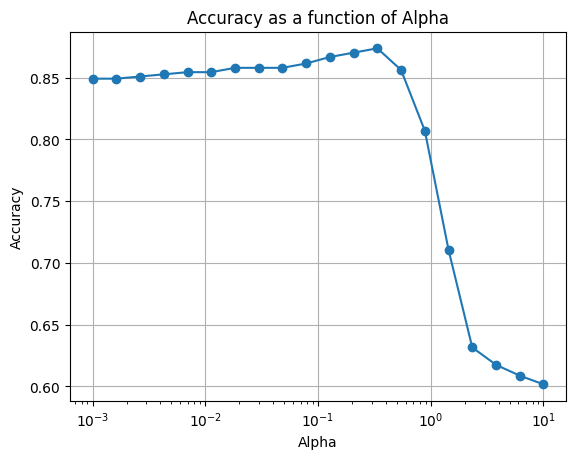

In [25]:
plt.figure()
plt.semilogx(alphas, acc, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of Alpha')
plt.grid(True)
plt.show()

## 8.3. Find the optimal $\alpha$ and its corresponding validation accuracy

**Hint**: [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [26]:
bestind = np.argmax(acc)
best_acc = acc[bestind]
best_alpha = alphas[bestind]

In [27]:
grader.check("q8p3")

q8p3 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [28]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)